# 4. Model Evaluation and Insights

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import datetime
import dill
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score

In [2]:
df=pd.read_csv('../dataset/reddit_final.csv')

In [3]:
# import pipelines

folder_path = '../models/'
mnb = dill.load(open(folder_path + 'cvec_mnb.sav', 'rb'))
lr = dill.load(open(folder_path + 'cvec_lr.sav', 'rb'))
knn = dill.load(open(folder_path + 'cvec_knn.sav', 'rb'))
rf = dill.load(open(folder_path + 'cvec_rf.sav', 'rb'))

In [4]:
# assign variable name to best estimator in all pipelines

mnb_pipe = mnb.best_estimator_.named_steps
lr_pipe = lr.best_estimator_.named_steps
knn_pipe = knn.best_estimator_.named_steps
rf_pipe = rf.best_estimator_.named_steps

In [5]:
df.cleaned_tokenised_post_no_punct_no_stopwords.fillna('', inplace=True)

In [6]:
X = df['post_EDA_lemmatized_stemmed']
y = df['subreddit_value']

In [7]:
#to keep the same balance of y in the test and train data

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state = 42)

In this section, we will examine the insights derived from the results of each model.


---
### Naive Bayes

In [8]:
print(f"There are {mnb_pipe.cvec.get_feature_names_out().shape[0]} text features after Gridsearch was performed. \
We will transform these columns only in the testset using CountVectorizer to determine the class probabilities.")

There are 3200 text features after Gridsearch was performed. We will transform these columns only in the testset using CountVectorizer to determine the class probabilities.


In [9]:
# modify test dataset to only keep the 3100 text features derived from gridsearch, convert to bag of words 
mnb_bow=pd.DataFrame(mnb_pipe.cvec.transform(X_test).toarray(),columns=mnb_pipe.cvec.get_feature_names_out())
mnb_bow

,aa,aatrox,ab,abaddon,abandon,abil,abl,absolut,absurd,abus,...,zhao,zhonya,zigg,zix,zma,znpsjk,zoe,zone,zwlmc,zyra
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
506,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
507,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
508,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# use multinomial NB to estimate the probability of a subreddit being LoL given that a particular word exists

mnb_df=pd.DataFrame(mnb.best_estimator_.predict_proba(mnb_bow),
                    index=mnb_pipe.cvec.get_feature_names_out()).rename(columns={0:'LoL',1:'Dota 2'})
mnb_df.sort_values(by='LoL',ascending=False).head(10)[['LoL']]

,LoL
champion,0.988048
champ,0.984960
riot,0.980964
adc,0.969887
yuumi,0.963375
elo,0.958476
leagueoflegend,0.955501
ash,0.950799
anni,0.948056
baron,0.948056


In [11]:
# use multinomial NB to estimate the probability of a subreddit being Dota 2 given that a particular word exists

mnb_df.sort_values(by='Dota 2',ascending=False).head(10)[['Dota 2']]

,Dota 2
valv,0.991932
muerta,0.985699
bkb,0.979771
dpc,0.977193
dota,0.975641
fp,0.971041
quickcast,0.969390
hero,0.967755
hammer,0.965449
offlan,0.965449


From above dataframes, we managed to populate the top 10 keywords that are likely to predict a Dota 2 or LoL post. Some similarities are observed both groups of text, such as the in-game characters, items and game role (adc and offlane). However, there are some differences noted as well. In the LoL dataframe, one of the keywords (elo) refers to the matchmaking/rating system. In the Dota 2 dataframe, one of the keywords (fp) refers to fps, where in context, most of the posts mentioned "fps drop", which suggests players have issues getting a smooth gameplay experience.

---
### Logistic Regression

In [12]:
print(f"There are {lr_pipe.logreg.coef_[0].shape[0]} text features after Gridsearch was performed. \
We will combine with the feature names from CountVectorizer to get the beta coefficients.")

There are 3789 text features after Gridsearch was performed. We will combine with the feature names from CountVectorizer to get the beta coefficients.


In [13]:
# beta coefficients from logistic regression

beta_coef=lr_pipe.logreg.coef_[0]
beta_coef

array([-0.21694872, -0.0099451 ,  0.        , ...,  0.        ,
        0.        , -0.07542513])

In [14]:
# features from gridsearch with logistic regression

lr_features=lr.best_estimator_.named_steps.cvec.get_feature_names_out()
lr_features

array(['aa', 'aaa', 'aac', ..., 'zwlmc', 'zyra', 'zz'], dtype=object)

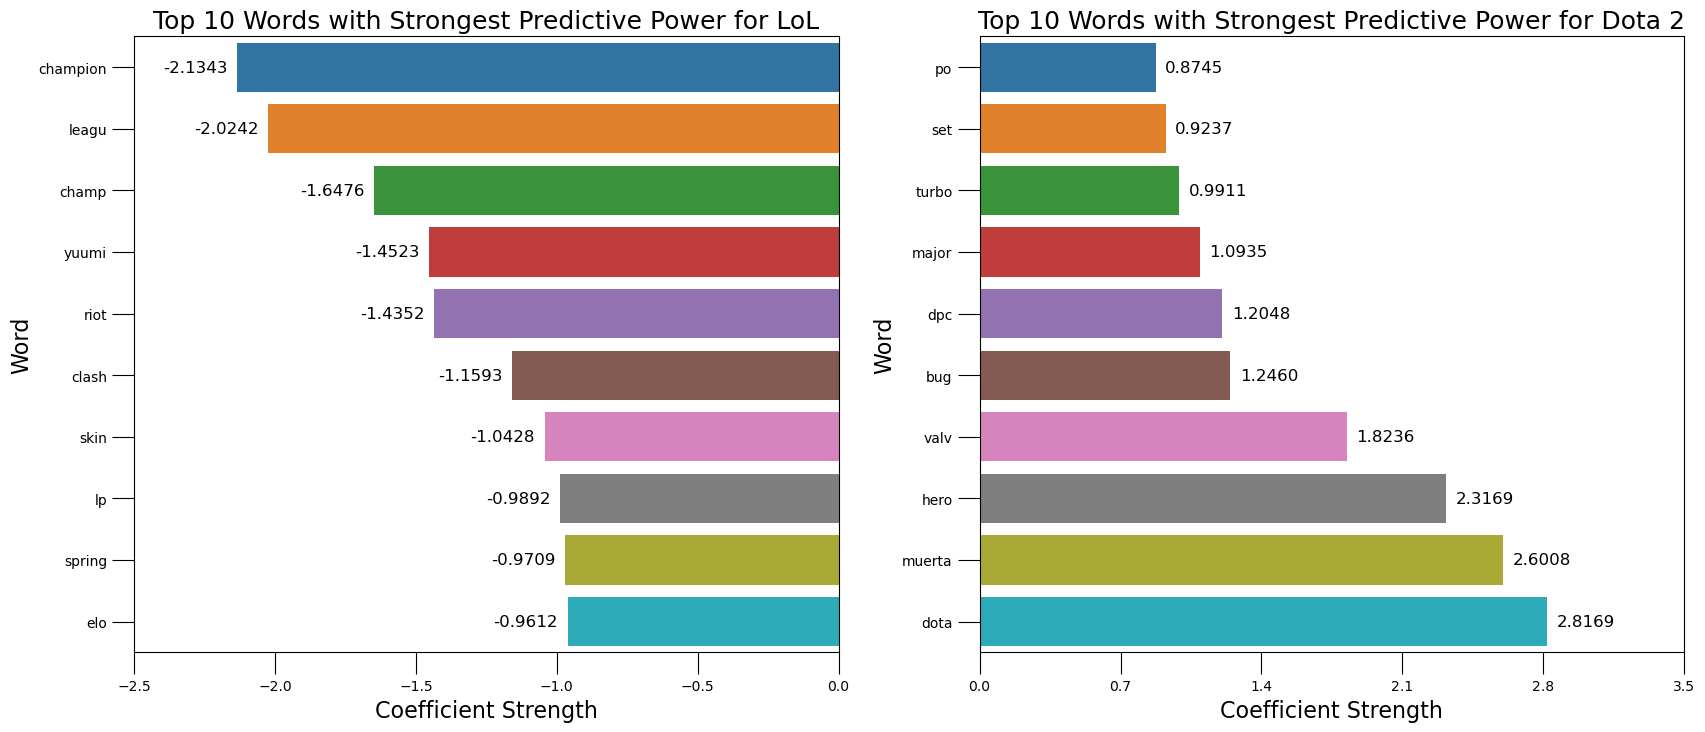

In [15]:
#predicting the strongest keywords for LoL and Dota 2 from logistic regression 

lr_lol_predictors = []
lr_dota2_predictors = []

for x in sorted(list(zip(beta_coef,lr_features)))[0:10]:
    feat = {}
    feat['Feature'] = x[1]
    feat['Coefficient'] = x[0]
    lr_lol_predictors.append(feat)

for x in sorted(list(zip(beta_coef,lr_features)))[-10:]:
    feat = {}
    feat['Feature'] = x[1]
    feat['Coefficient'] = x[0]
    lr_dota2_predictors.append(feat)

lr_lol_predictors = pd.DataFrame(lr_lol_predictors)
lr_dota2_predictors = pd.DataFrame(lr_dota2_predictors)

fig,axes=plt.subplots(1,2,figsize=(20,8))
sns.barplot(data=lr_lol_predictors, x='Coefficient', y='Feature',ax=axes[0]).set_facecolor('xkcd:white')
axes[0].set_xlabel('Coefficient Strength', size=16)
axes[0].set_ylabel('Word', size=16)
axes[0].set_xticks([-2.5,-2,-1.5,-1,-0.5,0])
axes[0].tick_params(axis='x',size=16)
axes[0].tick_params(axis='y',size=16)
axes[0].set_title('Top 10 Words with Strongest Predictive Power for LoL', size=18)
axes[0].bar_label(axes[0].containers[0],padding=7, fontsize=12, fmt='%.4f')
axes[0].grid(False)

sns.barplot(data=lr_dota2_predictors, x='Coefficient', y='Feature',ax=axes[1]).set_facecolor('xkcd:white')
axes[1].set_xlabel('Coefficient Strength', size=16)
axes[1].set_ylabel('Word', size=16)
axes[1].set_xticks([0,0.7,1.4,2.1,2.8,3.5])
axes[1].tick_params(axis='x',size=16)
axes[1].tick_params(axis='y',size=16)
axes[1].set_title('Top 10 Words with Strongest Predictive Power for Dota 2', size=18)
axes[1].bar_label(axes[1].containers[0],padding=7, fontsize=12, fmt='%.4f')
axes[1].grid(False)

plt.show()

From above plot, we managed to populate the top 10 keywords that are likely to predict a Dota 2 or LoL post, based on the coefficients associated with a particular word. As we assigned a value of 0 to LoL posts and a value of 1 to Dota 2 posts previously, from the logit function, the features that respond to Dota 2 will take on positive coefficients and those that respond to LoL will be negative. However, a large coefficient magnitude implies that a feature is important, regardless of whether it is favouring Dota 2 or LoL. 

---
### Random Forest

In [16]:
print(f"There are {rf_pipe.cvec.get_feature_names_out().shape[0]} text features after Gridsearch was performed. \
We will transform these columns only in the testset using CountVectorizer to determine the class probabilities.")

There are 2248 text features after Gridsearch was performed. We will transform these columns only in the testset using CountVectorizer to determine the class probabilities.


In [17]:
# modify test dataset to only keep the 3219 text features derived from gridsearch, convert to bag of words 
rf_bow=pd.DataFrame(rf_pipe.cvec.transform(X_test).toarray(),columns=rf_pipe.cvec.get_feature_names_out())
rf_bow

,aa,aatrox,ab,abandon,abil,abl,absolut,abus,abyss,ac,...,zac,zed,zeri,zero,zhonya,zigg,zix,zoe,zone,zyra
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
506,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
507,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
508,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
#feature importance in random forest

rf.best_estimator_.named_steps.rf.feature_importances_

array([1.96350434e-04, 4.18246944e-04, 1.19307128e-04, ...,
       0.00000000e+00, 1.44842963e-04, 2.10829106e-05])

In [19]:
rf_features=pd.DataFrame(list(zip(rf.best_estimator_.named_steps.cvec.get_feature_names_out(),rf.best_estimator_.named_steps.rf.feature_importances_)))\
.rename(columns={0:'Feature',1:'Coefficient'}).sort_values(by='Coefficient',ascending=False).reset_index(drop=True)

rf_features

,Feature,Coefficient
0,champion,0.031109
1,leagu,0.026655
2,champ,0.024843
3,dota,0.024477
4,muerta,0.020091
...,...,...
2243,fairli,0.000000
2244,scope,0.000000
2245,contribut,0.000000
2246,resourc,0.000000


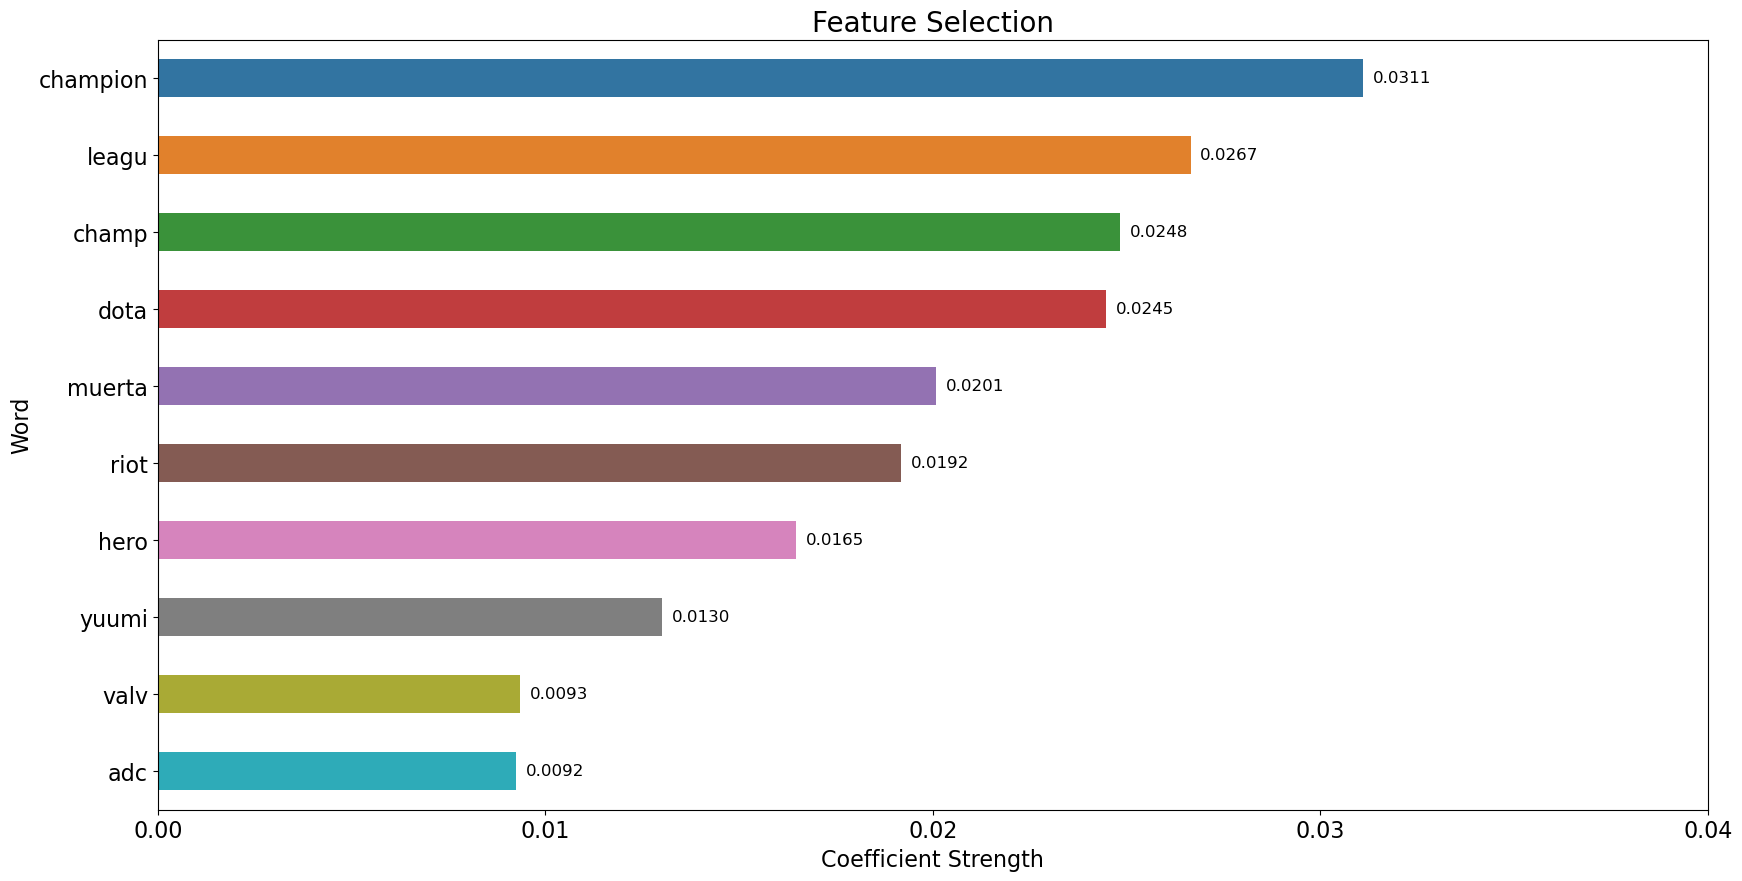

In [26]:
fig,axes=plt.subplots(1,1,figsize=(20,10))
sns.barplot(data=rf_features[0:10],x='Coefficient',y='Feature',width=0.5).set_facecolor('xkcd:white')
axes.set_xticks([0,0.01,0.02,0.03,0.04])
axes.bar_label(axes.containers[0],padding=7, fontsize=12, fmt='%.4f')
axes.grid(False)
axes.set_title('Feature Selection',size=20)
plt.xlabel('Coefficient Strength', size=16)
plt.ylabel('Word', size=16)
plt.yticks(size=16)
plt.xticks(size=16)
plt.show()

From the Random Forest model, we are able to rank the text by feature importance. A higher coefficient suggests a more important feature, which also equates to easier splitting at decision nodes. The top 10 words with the highest coefficients are a mix of keywords from both Dota 2 and LoL posts, as seen from the earlier models. Therefore, the results from Random Forest is consistent with those from Naive Bayes and Logistic Regression.

---
### Conclusion & Recommendations

From above discussion regarding various model insights, we can propose a few actions to capture the interest of the gaming community. With the results from Naive Bayes, it might be worth revisting the matchmaking rating (MMR) system in Dota 2 to calibrate the skill levels amongst the player base and also pay more attention to the concerns of gamers that experience FPS issues, which might be related to the game client itself. With the results from Logistic Regression, we can also introduce rewards to engage the gaming community to help out with bug testing and further improve the gameplay experience, such as the design of cosmetics (otherwise known as skins) or other gaming features (eg. voicelines, stickers etc).

### Future Work

On top of current findings, there are several things that can be examined to further improve our models. As Dota 2 and LoL are unlikely to stop running anytime soon due to their popularity in the MOBA market, periodic text data collection can be done. We would foresee new text appearing as new game changes come along eventually. Further stopword optimization can be done as well to check for model accuracy improvement, this would likely be the elimination of words that occur repeatedly in both Dota 2 and LoL posts as prior data cleaning has been done to eliminate unwanted noise (eg. web URLs containing http and newline denoted by \n). Lastly, more pipeline transformers and classifiers can be explored with their respective hyperparameter optimization.